### Token model for multiple detect
- load dataset
- train model

In [1]:
import os
import gc
import time
import random
import pickle
import math
import numpy as np
import torch
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
from torch.utils.data import DataLoader as Dataloader_dsm, Dataset
from torch_geometric.loader import DataLoader as Dataloader_dot
from torch_geometric.nn import MessagePassing, TopKPooling
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.utils import degree
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
# # GCN layer
# # cite: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
# class GCNConv(MessagePassing):
#     def __init__(self, in_channels, out_channels, **kwargs):
#         super().__init__(aggr='add', **kwargs)  # "Add" aggregation (Step 5).
#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.lin = Linear(in_channels, out_channels)
#
#     def forward(self, x, edge_index):
#         # x[N, in_channels]
#         # edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
#         x = self.lin(x)
#         row, col = edge_index
#
#         deg = degree(col, x.size(0), dtype=x.dtype)
#
#         deg_inv_sqrt = deg.pow(-0.5)
#         deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
#         norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
#         return  self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x, norm=norm)
#
#     def message(self, x_j, norm):
#         # x_j has shape [E, out_channels]
#
#         # Step 4: Normalize node features.
#         return norm.view(-1, 1) * x_j
#
#     def update(self, aggr_out):
#         # aggr_out has shape [N, out_channels]
#         # Step 6: Return new node embeddings.
#         return aggr_out

In [3]:
class TokenNet(torch.nn.Module):
	def __init__(self, size0, size1):
		super(TokenNet, self).__init__()
		###############################################################################
		# GCN model   																  #
		###############################################################################
		# self.conv1 = GCNConv(256, 256)
		# self.pool1 = TopKPooling(256, ratio=0.8)
		# self.conv2 = GCNConv(256, 256)
		# self.pool2 = TopKPooling(256, ratio=0.8)
		# self.conv3 = GCNConv(256, 256)
		# self.pool3 = TopKPooling(256, ratio=0.8)
		# self.conv4 = GCNConv(256, 256)
		# self.pool4 = TopKPooling(256, ratio=0.8)
		# self.conv5 = GCNConv(256, 256)
		# self.pool5 = TopKPooling(256, ratio=0.8)
		#
		# self.convAtt1 = torch.nn.Conv1d(in_channels=512, out_channels=64, kernel_size=1, stride=2)
		# self.poolAtt1 = torch.nn.MaxPool1d(kernel_size=1, stride=2)
		# self.convAtt2 = torch.nn.Conv1d(64, 16, kernel_size=1, stride=2)
		# self.poolAtt2 = torch.nn.MaxPool1d(kernel_size=1, stride=2)
		# self.convAtt3 = torch.nn.Conv1d(16, 2, kernel_size=1, stride=2)
		# self.poolAtt3 = torch.nn.MaxPool1d(kernel_size=1, stride=2)
		#
		# self.convAtt4 = torch.nn.Conv1d(2, 16, kernel_size=1, stride=2)
		# self.poolAtt4 = torch.nn.MaxPool1d(kernel_size=1, stride=2)
		# self.convAtt5 = torch.nn.Conv1d(16, 64, kernel_size=1, stride=2)
		# self.poolAtt5 = torch.nn.MaxPool1d(kernel_size=1, stride=2)
		# self.convAtt6 = torch.nn.Conv1d(64, 512, kernel_size=1, stride=2)
		# self.poolAtt6 = torch.nn.MaxPool1d(kernel_size=1, stride=2)

		###############################################################################
		# textCNN model   															  #
		###############################################################################
		h_input = size0
		w_input = size1
		filter_list = [2, 4, 6, 8, 10, 12, 16, 20]
		num_per_filter = 64
		h_raw = [h_input - i + 1 for i in filter_list]  # 175-filter_size+1: after conv
		filter_list1 = [math.ceil(i / 2) for i in h_raw]  # p = ceil[h_raw / 2]
		self.num_filter = len(filter_list)
		self.conv_t = nn.ModuleList([nn.Conv2d(1, num_per_filter, (cnv_size, w_input)) for cnv_size in filter_list])
		self.max_t = nn.MaxPool2d(kernel_size=(num_per_filter, 1))
		self.avg_t = nn.AvgPool2d(kernel_size=(num_per_filter, 1))
		self.conv_t1 = nn.ModuleList([nn.Conv2d(2, 1, (cnv_size, 1), padding='same') for cnv_size in filter_list1])
		self.sig = nn.Sigmoid()
		h_res = sum(h_raw)  # textCNN_input_feature
		self.lin0_ = torch.nn.Linear(h_res, 512)
		###############################################################################
		# hybrid output   															  #
		###############################################################################
		# x: cfg  t:dsm
		# self.ratio = 0.5
		# r_dot = round(self.ratio * 1024)
		# r_dsm = 1024 - r_dot
        #
		# self.lin0x_ = torch.nn.Linear(512, r_dot)
		# self.lin0t_ = torch.nn.Linear(512, r_dsm)

		# self.lin1_ = torch.nn.Linear(1024, 512)
		self.lin2_ = torch.nn.Linear(512, 128)
		self.lin3_ = torch.nn.Linear(128, 64)
		self.lin4_ = torch.nn.Linear(64, 6)
		self.dropout_ = nn.Dropout(0.6)

	def forward(self, x, edge_index, batch, t):
		###############################################################################
		# GCN model :  x, edge_index, batch = data.x, data.edge_index, data.batch	  #
		###############################################################################
		# x = F.relu(self.conv1(x, edge_index))
		# x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
		# x1 = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)
		#
		# x = F.relu(self.conv2(x, edge_index))
		# x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
		# x2 = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)
		#
		# x = F.relu(self.conv3(x, edge_index))
		# x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, None, batch)
		# x3 = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)
		#
		# x = F.relu(self.conv4(x, edge_index))
		# x, edge_index, _, batch, _, _ = self.pool4(x, edge_index, None, batch)
		# x4 = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)
		#
		# x = F.relu(self.conv5(x, edge_index))
		# x, edge_index, _, batch, _, _ = self.pool5(x, edge_index, None, batch)
		# x5 = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)
		#
		# x = x1 + x2 + x3 + x4 + x5
		#
		# x = 1 / 5 * x
		#
		# sx = x
		#
		# x = x.unsqueeze(dim=2)
		#
		# # attention
		# x = F.relu(self.convAtt1(x))
		# x = self.poolAtt1(x)
		# x = F.relu(self.convAtt2(x))
		# x = self.poolAtt2(x)
		# x = F.relu(self.convAtt3(x))
		# x = self.poolAtt3(x)
		#
		# x = F.relu(self.convAtt4(x))
		# x = self.poolAtt4(x)
		# x = F.relu(self.convAtt5(x))
		# x = self.poolAtt5(x)
		# x = F.relu(self.convAtt6(x))
		# x = self.poolAtt6(x)
		# x = x.squeeze()
		#
		# x = (x + 1) * sx

		###############################################################################
		# TextCNN model :  t = batch * h * w										  #
		###############################################################################
		t = torch.unsqueeze(t, 1)
		t = [torch.squeeze(F.relu(conv(t)), 3) for conv in self.conv_t]
		# per_filter * [batch * num_per_filter * h_raw]

		for i in range(0, self.num_filter):
			t[i] = torch.unsqueeze(t[i], 1)
			# [batch * 1 * num_per_filter * h_raw]
			max_ = torch.unsqueeze(torch.squeeze(self.max_t(t[i]), 1), 3)
			avg_ = torch.unsqueeze(torch.squeeze(self.avg_t(t[i]), 1), 3)

			attention_ = torch.cat((max_, avg_), dim=1)
			attention_ = self.sig(self.conv_t1[i](attention_))
			attention_ = torch.unsqueeze(torch.squeeze(attention_, 3), 1)
			t[i] = t[i] * attention_
			t[i] = torch.squeeze(self.max_t(t[i]))
		t = torch.cat(t, dim=1)
		t = torch.squeeze(t)
		t = F.relu(self.lin0_(t))
		###############################################################################
		# hybrid output :  #
		###############################################################################
		# out layer
		# self.lin0x_ = torch.nn.Linear(512, r_dot)
		# self.lin0t_ = torch.nn.Linear(512, r_dsm)
        # if self.ratio != 0.5:
		#   x = F.relu(self.lin0x_(x))
		#   t = F.relu(self.lin0t_(t))

		# x = torch.cat((x, t), dim=1)  # 512 + 512

		# t = F.relu(self.lin1_(t))
		t = F.relu(self.lin2_(t))
		t = F.relu(self.lin3_(t))
		t = F.dropout(t, p=0.5, training=self.training)
		t = F.log_softmax(self.lin4_(t), dim=-1)

		return t


In [4]:
class MyDataset(Dataset):
    def __init__(self, dataset_, size_):
        for idx, data_ in enumerate(dataset_):
            data_len_ = len(data_)
            if data_len_ < size_[0]:
                pad = torch.zeros(size_[0] - data_len_, size_[1])
                dataset_[idx] = torch.cat((data_, pad), dim=0)
            else:
                dataset_[idx] = data_[:size_[0]]
        self.dateset = dataset_
        self.size = size_

    def __len__(self):
        return len(self.dateset)

    def __getitem__(self, idx):
        return self.dateset[idx]

In [5]:
# init model
size_ = [175, 45]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TokenNet(size_[0], size_[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
def train(Train_dot_loader, Train_dsm_loader):
	model.train()
	loss_all = 0
	iter_loader = iter(Train_dsm_loader)
	for data in Train_dot_loader:
		data1 = next(iter_loader)
		data1 = data1.to(device)
		data = data.to(device)

		optimizer.zero_grad()

		x, edge_index, batch = data.x, data.edge_index, data.batch
		output = model(x, edge_index, batch, data1)
		loss = F.nll_loss(output, data.y)
		loss.backward()
		loss_all += data.num_graphs * loss.item()
		optimizer.step()
	return loss_all / len(Train_dot_loader.dataset)

In [7]:
def test(loader0, loader1):
	# loader0:dot loader1:dsm
	model.eval()
	correct = 0
	iter_loader = iter(loader1)
	pred_list, true_list = np.array(0), np.array(0)
	for data0 in loader0:
		data1 = next(iter_loader)
		data1 = data1.to(device)
		data0 = data0.to(device)
		optimizer.zero_grad()
		x, edge_index, batch = data0.x, data0.edge_index, data0.batch
		y_pred = model(x, edge_index, batch, data1)
		y_pred = y_pred.max(dim=1)[1]
		pred_list = np.append(pred_list, y_pred.to('cpu').numpy())
		true_list = np.append(true_list, data0.y.to('cpu').numpy())
		correct += y_pred.eq(data0.y).sum().item()
	acc = correct / len(loader0.dataset)
	return round(acc, 6), pred_list, true_list

In [8]:
# main:
start_time = time.time()

with open(rf'D:\Desktop\hybrid-SVD\dataset\multi_test.pk', 'rb') as f_:
	cur_dataset = pickle.load(f_)
	random.shuffle(cur_dataset)
	test_dsm = []
	test_dot = []
	for d in cur_dataset:
		test_dot.append(d[0])
		test_dsm.append(d[1])
	del cur_dataset
	gc.collect()
	Test_dot_loader = Dataloader_dot(test_dot, batch_size=32, shuffle=False, drop_last=True)
	Test_dsm_loader = Dataloader_dsm(MyDataset(test_dsm, size_), batch_size=32, shuffle=False, drop_last=True)

all_loss_list = []
avg_loss_list = []
acc_list = []
best_model = None
best_acc = {'acc': 0, 'epoch': 0}

for epoch in range(0, 80):
	print("===>epoch:{:03d}===>".format(epoch))
	loss_list = []
	for i_ in range(0, 4):
		with open(rf'D:\Desktop\hybrid-SVD\dataset\multi_train{i_}.pk', 'rb') as f_:
			cur_dataset = pickle.load(f_)
			random.shuffle(cur_dataset)
			train_dsm = []
			train_dot = []
			for d in cur_dataset:
				train_dot.append(d[0])
				train_dsm.append(d[1])
			del cur_dataset
			gc.collect()
			Train_dot_loader = Dataloader_dot(train_dot, batch_size=32, shuffle=False, drop_last=True)
			Train_dsm_loader = Dataloader_dsm(MyDataset(train_dsm, size_), batch_size=32, shuffle=False, drop_last=True)
			loss = train(Train_dot_loader, Train_dsm_loader)
			loss_list.append(loss)
			all_loss_list.append(loss)
			if epoch % 1 == 0:
				acc, _, _ = test(Train_dot_loader, Train_dsm_loader)
				print("#train_set:{:d}, loss:{:.5f}, Train_acc:{:.5f}".format(i_, loss, acc))
			if epoch % 1 == 0 and i_ == 3:
				avg_loss = math.fsum(loss_list) / 4
				avg_loss_list.append(avg_loss)
				print("avg loss:{:.5f}".format(avg_loss))

	if epoch % 1 == 0:
		acc, y_pred, y_true = test(Test_dot_loader, Test_dsm_loader)
		acc_list.append(acc)
		if acc > best_acc['acc']:
			best_acc['acc'], best_acc['epoch'] = acc, epoch
			best_model = model
		print("Test_acc:{:.5f}".format(acc))
		measure_result = classification_report(y_true[1:], y_pred[1:])
		print('measure_result = \n', measure_result)
		print("Time span:{:.5f}".format(time.time() - start_time))

print("Total time span:{:.5f}".format(time.time() - start_time))

===>epoch:000===>


D:\Develop\Miniconda\envs\pytorch\lib\site-packages\torch\nn\modules\conv.py:453: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:883.)
  return F.conv2d(input, weight, bias, self.stride,


#train_set:0, loss:1.29774, Train_acc:0.60039
#train_set:1, loss:0.93350, Train_acc:0.76172
#train_set:2, loss:0.67594, Train_acc:0.79766
#train_set:3, loss:0.49910, Train_acc:0.83594
avg loss:0.85157
Test_acc:0.83880
measure_result = 
               precision    recall  f1-score   support

           0       0.82      0.92      0.86      1297
           1       0.89      0.95      0.92       218
           2       0.00      0.00      0.00       133
           3       0.00      0.00      0.00       153
           4       0.86      0.98      0.92       669
           5       0.88      0.94      0.91       154

    accuracy                           0.84      2624
   macro avg       0.57      0.63      0.60      2624
weighted avg       0.75      0.84      0.79      2624

Time span:50.27985
===>epoch:001===>


D:\Develop\Miniconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Develop\Miniconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Develop\Miniconda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#train_set:0, loss:0.41073, Train_acc:0.87500
#train_set:1, loss:0.40069, Train_acc:0.86758
#train_set:2, loss:0.38741, Train_acc:0.87344
#train_set:3, loss:0.33821, Train_acc:0.85977
avg loss:0.38426
Test_acc:0.84299
measure_result = 
               precision    recall  f1-score   support

           0       0.81      0.98      0.88      1297
           1       0.96      0.84      0.90       218
           2       1.00      0.01      0.01       133
           3       0.87      0.13      0.23       153
           4       0.88      0.92      0.90       669
           5       0.92      0.84      0.88       154

    accuracy                           0.84      2624
   macro avg       0.91      0.62      0.63      2624
weighted avg       0.86      0.84      0.80      2624

Time span:93.28212
===>epoch:002===>
#train_set:0, loss:0.28648, Train_acc:0.90156
#train_set:1, loss:0.28387, Train_acc:0.90977
#train_set:2, loss:0.27515, Train_acc:0.89766
#train_set:3, loss:0.24678, Train_acc:0.90703

In [9]:
# show res
print("best acc:{:.5f}, at epoch:{:3d}".format(best_acc['acc'], best_acc['epoch']))

best acc:0.96532, at epoch: 69


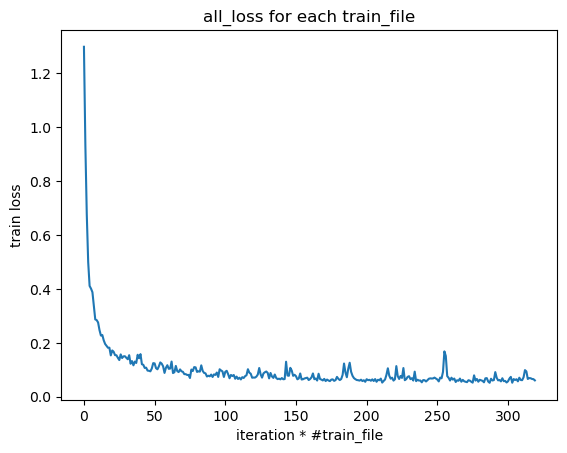

In [10]:
x = np.arange(0, 320, 1)
plt.title("all_loss for each train_file")
plt.xlabel("iteration * #train_file")
plt.ylabel("train loss")
plt.plot(x, all_loss_list)

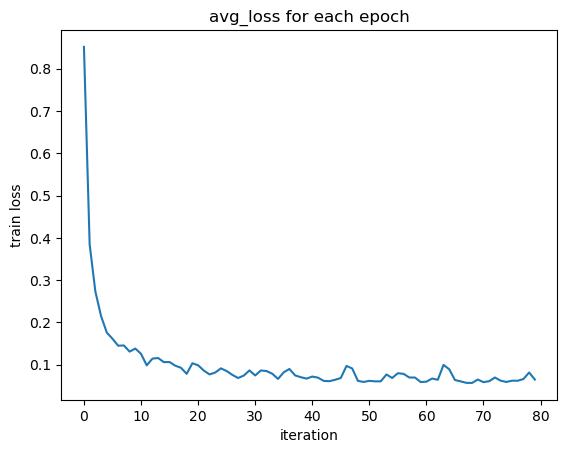

In [11]:
x = np.arange(0, 80, 1)
plt.title("avg_loss for each epoch")
plt.xlabel("iteration")
plt.ylabel("train loss")
plt.plot(x, avg_loss_list)

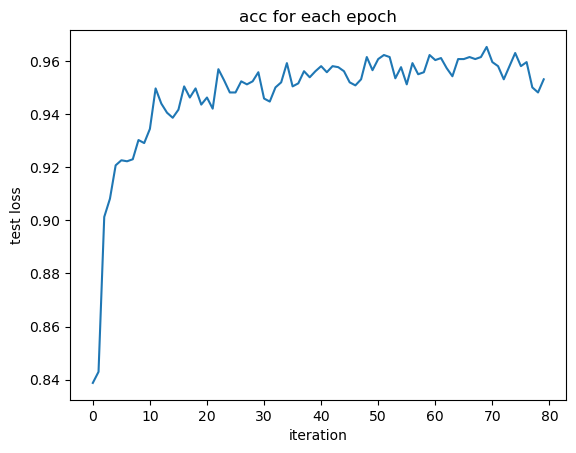

In [12]:
x = np.arange(0, 80, 1)
plt.title("acc for each epoch")
plt.xlabel("iteration")
plt.ylabel("test loss")
plt.plot(x, acc_list)